# EDA Customer in Supermarket

## Import Data and Clean the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from matplotlib.pyplot import figure
import seaborn as sns
import datetime

In [2]:
df = pd.DataFrame()

### Build function which creates one single DF out the different weekday .csv

In [2]:
# Create a single DF out of the different weekday files
# Add checkout stamp for certain customers since when the supermarket is closing, some customer are not recorded as checked out. 
# Renumber the customer_no, since all customer_no start with 1 again in the different daily .csv files. c
# customer_no will continue from the customer_no from the previous day.
def create_df():    
    df = pd.DataFrame()
    counter = 0
    number_of_cust = 0
    
    # read the single .csv files by a loop
    for weekday in ["monday","tuesday","wednesday","thursday","friday"]:
        df_weekday = pd.DataFrame()
        df_weekday = pd.read_csv(f".././data/{weekday}.csv",sep = ";", index_col = 0, parse_dates=True )
        
        if weekday!="monday": #if the weekday is monday, the counter stays zero, since no data from the previous day need to be added
            df_weekday["customer_no"] =  df_weekday["customer_no"] + counter
        
        # set a counter, which counts the customers of the previous days and than adds them to currently loaded customer file.
        counter += df_weekday["customer_no"].nunique()   
        
        # Check which customer have not checkout
        df_no_dup = df_weekday.drop_duplicates(subset=['customer_no'],keep='last')
        df_no_dup = df_no_dup.loc[(df_no_dup["location"]!="checkout")]
       
        # create a DF coLumn whcih contains onLy "checkout" 
        checkout_list = []
        for i in range(0,len(df_no_dup)):
            checkout_list.append("checkout")
        checkout_list
        df_no_dup["location"] = checkout_list

        # create a list with timestamp of the date and last hour 22:00:00
        time_list = []
        for i in range(0,len(df_no_dup)):
            time_list.append(datetime.datetime.combine(df_no_dup.index[0].date(), 
                                  datetime.time(22, 0,0)))

        # resets the index of the checkout-df to the date and 22:00:00
        df_no_dup.index=time_list
        
        #add the checkout df to the original df
        df_weekday = pd.concat([df_weekday,df_no_dup])
        df = pd.concat([df,df_weekday])
    #print(counter)
    return(df)





In [3]:
# create a new df containing all weekdays
df_week= create_df()


In [4]:
#create new coLumn with the respective weekday as string
df_week["weekday"] = df_week.index.strftime('%A')
df_week.head(), df_week.tail()

(                     customer_no location weekday
 2019-09-02 07:03:00            1    dairy  Monday
 2019-09-02 07:03:00            2    dairy  Monday
 2019-09-02 07:04:00            3    dairy  Monday
 2019-09-02 07:04:00            4    dairy  Monday
 2019-09-02 07:04:00            5   spices  Monday,
                      customer_no  location weekday
 2019-09-06 22:00:00         7440  checkout  Friday
 2019-09-06 22:00:00         7431  checkout  Friday
 2019-09-06 22:00:00         7435  checkout  Friday
 2019-09-06 22:00:00         7444  checkout  Friday
 2019-09-06 22:00:00         7445  checkout  Friday)

In [5]:
# calculate the probability at which supermarket departement the customer will start
df_starting = df_week.drop_duplicates(subset=['customer_no'],keep='first') # create df only with starting positions
df_starting = df_starting.groupby("location").count()
df_starting["start_prob"] = df_starting["customer_no"]/df_starting["customer_no"].sum()
df_starting = df_starting["start_prob"] 

# create a list with starting probabilities
prob=df_starting.to_list()
startlocation = np.random.choice(["dairy","drinks","fruit","spices"], size=1, p=prob)[0]
print(startlocation)


dairy


In [6]:
print(prob)

[0.2875755540631296, 0.15352585627938214, 0.3774345198119543, 0.18146406984553393]


### Total numbers of customers in the supermarket

In [7]:
# amount of customer which have benn at the supermarket at a given time
df_no_customer_hour = df_week.groupby([df_week.index.weekday,df_week.index.strftime('%A'), df_week.index.hour]).count()
df_no_customer_hour[["customer_no"]]

customer_no
0 Monday 7           317
         8           364
         9           308
         10          282
         11          189
...                  ...
4 Friday 18          548
         19          453
         20          335
         21          181
         22            8

[80 rows x 1 columns]

<AxesSubplot:>

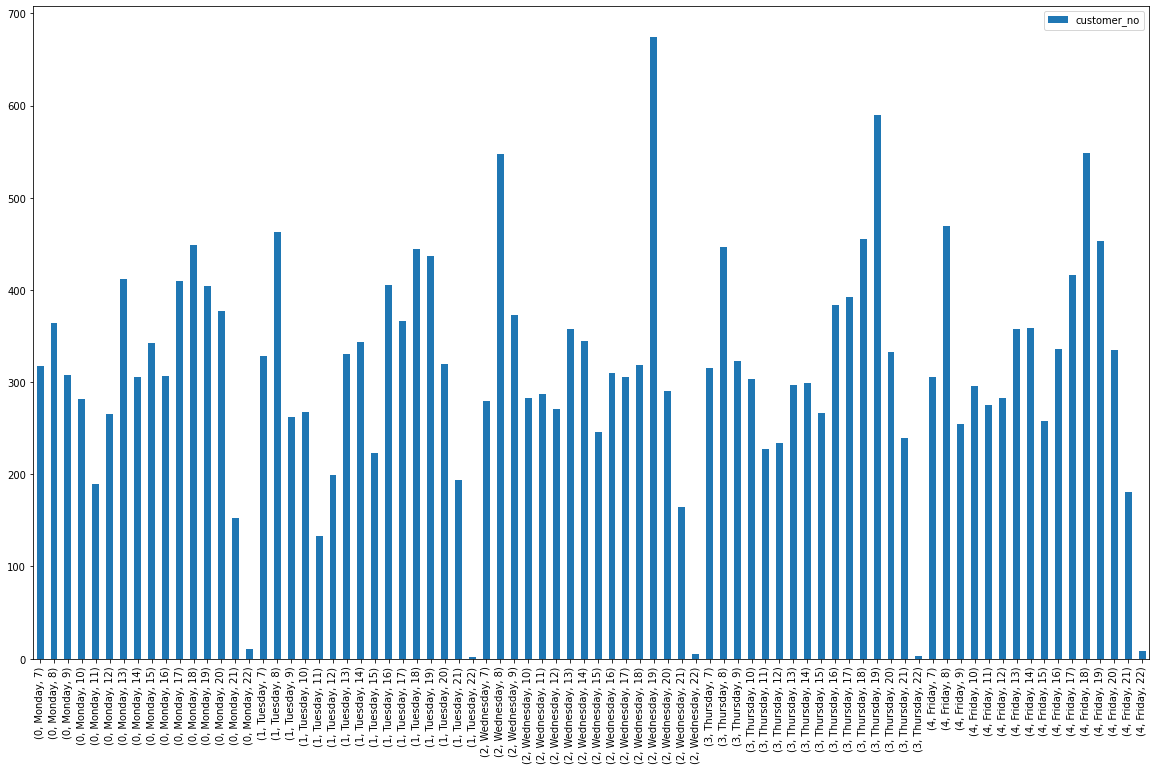

In [8]:
#plot the no of customer per hour over the week
df_no_customer_hour.plot.bar(y="customer_no", figsize=(20,12))

### Total Numbers of customers per area

<AxesSubplot:xlabel='location', ylabel='customer_no'>

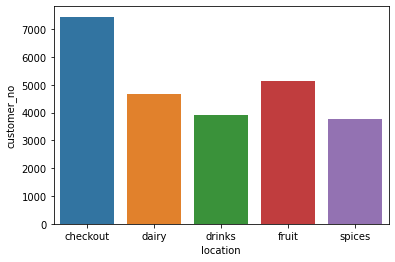

In [9]:
sns.barplot(data=df_week.groupby("location").count(),x=df_week.groupby("location").count().index,y="customer_no")

### Total numbers of customers in one week

In [10]:
df_week["customer_no"].nunique()

7445

## Time in Supermarket

### Create DF to calculate how long customers spent in the supermarket

In [11]:
df_week["time"] = df_week.index
df_enter_super= df_week.drop_duplicates(subset ="customer_no",
                     keep = "first")#.append(df_week.drop_duplicates(subset ="customer_no",
                     #keep = "last")).sort_values("customer_no")

df_checkout_super=df_week.drop_duplicates(subset ="customer_no",
                     keep = "last")
#df_test = df_test1.append(df_test2)
df_time_in_super = pd.merge(df_enter_super, df_checkout_super, left_on="customer_no", right_on="customer_no")
df_time_in_super .sort_values("customer_no")

df_time_in_super ["timediff"] = df_time_in_super ["time_y"] - df_time_in_super ["time_x"] 

df_time_in_super .head(2)

,customer_no,location_x,weekday_x,time_x,location_y,weekday_y,time_y,timediff
0,1,dairy,Monday,2019-09-02 07:03:00,checkout,Monday,2019-09-02 07:05:00,0 days 00:02:00
1,2,dairy,Monday,2019-09-02 07:03:00,checkout,Monday,2019-09-02 07:06:00,0 days 00:03:00


### Minutes customers spent in the supermarket

In [12]:
# average time customer spent at supermarket
df_time_in_super["timediff"].mean()

Timedelta('0 days 00:06:16.964405641')

In [13]:
#maximum time a customer spent in the super market
df_time_in_super["timediff"].max()

Timedelta('0 days 00:52:00')

## Transition Matrix

### Create a matrix with shifted vaLues to cacuLate transition matrix

In [14]:
# create dataframe which shows the current location/with time and the next_location of the customer with time
df_shifted = df_week.sort_values(["customer_no","time"])
df_shifted["next_location"] = df_shifted["location"].shift(-1)
df_shifted=df_shifted.loc[df_shifted["location"]!="checkout"]
df_shifted.head(10)

,customer_no,location,weekday,time,next_location
2019-09-02 07:03:00,1,dairy,Monday,2019-09-02 07:03:00,checkout
2019-09-02 07:03:00,2,dairy,Monday,2019-09-02 07:03:00,checkout
2019-09-02 07:04:00,3,dairy,Monday,2019-09-02 07:04:00,checkout
2019-09-02 07:04:00,4,dairy,Monday,2019-09-02 07:04:00,checkout
2019-09-02 07:04:00,5,spices,Monday,2019-09-02 07:04:00,checkout
2019-09-02 07:04:00,6,spices,Monday,2019-09-02 07:04:00,dairy
2019-09-02 07:05:00,6,dairy,Monday,2019-09-02 07:05:00,spices
2019-09-02 07:17:00,6,spices,Monday,2019-09-02 07:17:00,drinks
2019-09-02 07:18:00,6,drinks,Monday,2019-09-02 07:18:00,spices
2019-09-02 07:25:00,6,spices,Monday,2019-09-02 07:25:00,dairy


### Create transition  matrix

In [15]:
# create transition matrix between Location and next_Location
df_matrix = pd.crosstab(df_shifted["location"], df_shifted["next_location"],normalize="index")
df_matrix

next_location,checkout,dairy,drinks,fruit,spices
location,,,,,
dairy,0.393033,0.000000,0.222483,0.189357,0.195127
drinks,0.537260,0.027145,0.000000,0.218950,0.216645
fruit,0.500195,0.237993,0.136080,0.000000,0.125732
spices,0.251998,0.323122,0.272776,0.152104,0.000000


In [16]:
df_matrix.loc["dairy"].to_list()

[0.3930326992947211,
 0.0,
 0.22248343663175893,
 0.18935670014960462,
 0.19512716392391535]

<AxesSubplot:xlabel='next_location', ylabel='location'>

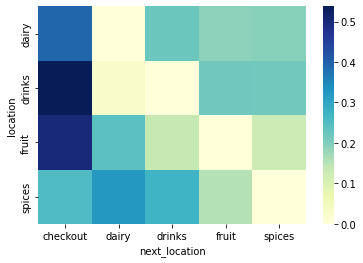

In [167]:
# create heatmap
sns.heatmap(df_matrix, cmap="YlGnBu")